# Word2Vector

## Imports

In [25]:
import glob
import nltk
import codecs
import re
import multiprocessing
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pd 

#### NLTK tokenizer models

In [2]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/ayush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ayush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

#### Load books from files

In [3]:
filenames = sorted(glob.glob("data/*.txt"))
print("Books")
filenames

Books


['data/got1.txt',
 'data/got2.txt',
 'data/got3.txt',
 'data/got4.txt',
 'data/got5.txt']

#### Combine the books into one string

In [4]:
corpus_raw = u""
for book_filename in filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data/got1.txt'...
Corpus is now 1770659 characters long

Reading 'data/got2.txt'...
Corpus is now 4071041 characters long

Reading 'data/got3.txt'...
Corpus is now 6391405 characters long

Reading 'data/got4.txt'...
Corpus is now 8107945 characters long

Reading 'data/got5.txt'...
Corpus is now 9719485 characters long



#### Split the corpus into sentences

In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

In [6]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [7]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [8]:
print(raw_sentences[10])
print(sentence_to_wordlist(raw_sentences[10]))

It was here the ravens came, after long flight.
['It', 'was', 'here', 'the', 'ravens', 'came', 'after', 'long', 'flight']


In [9]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0} tokens.".format(token_count))

The book corpus contains 1818103 tokens.


## Train Word2Vec

In [10]:
# Dimensionality of the resulting word vectors
num_features = 300

# Minimum word count threshold
min_word_count = 3

# Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()

# Context window length
context_size = 7

# Downsample setting for frequent words
downsampling = 1e-3

# Seed 
seed = 1

In [11]:
word2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    vector_size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling)

In [12]:
word2vec.build_vocab(sentences)

In [13]:
print("Word2Vec vocabulary length:", len(word2vec.wv))

Word2Vec vocabulary length: 17277


In [14]:
word2vec.train(sentences,
              total_examples=word2vec.corpus_count,
              epochs=1)


(1404172, 1818103)

## Compress the word vectors into 2D space and plot

In [15]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [16]:
all_word_vectors_matrix = word2vec.syn1neg

In [17]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

#### Plot the big picture

In [18]:
points = pd.DataFrame(
    [(word, coords[0], coords[1]) for word, coords in 
    [(word, all_word_vectors_matrix_2d[word2vec.wv.key_to_index[word]])for word in word2vec.wv.key_to_index]],
    columns=["word", "x", "y"])

In [19]:
points.head(10)

,word,x,y
0,the,-22.022144,-48.460888
1,and,-17.760469,-51.665524
2,to,-50.776524,-37.734505
3,of,-1.649662,-55.294739
4,a,-19.563536,-39.905235
5,his,-24.964514,-57.209648
6,was,-28.251797,-38.630348
7,I,-48.485443,-36.194855
8,he,-35.926533,-46.979618
9,s,-48.917278,-15.681646


<AxesSubplot:xlabel='x', ylabel='y'>

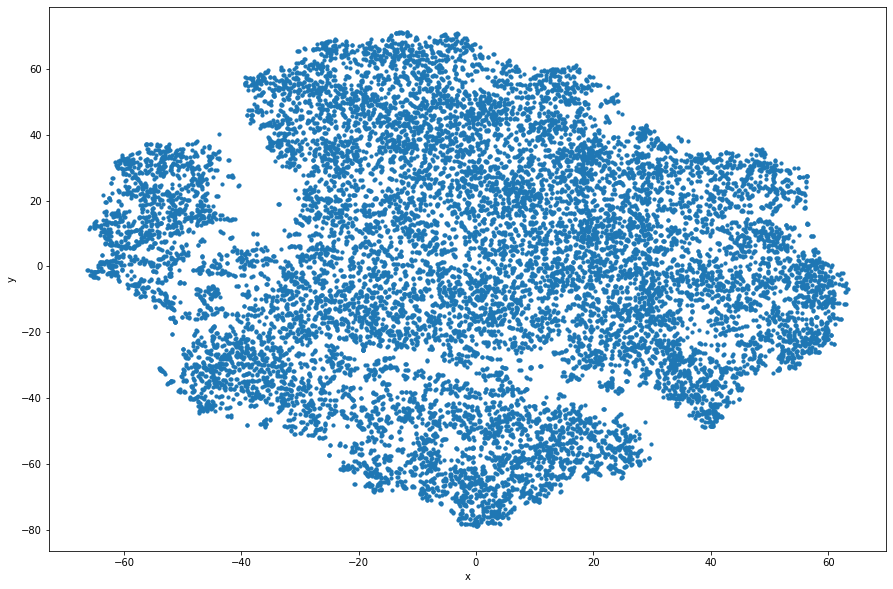

In [20]:
points.plot.scatter("x", "y", s=10, figsize=(15, 10))

#### Words closest to the given word

In [21]:
word2vec.wv.most_similar("Stark")

[('Eddard', 0.9504815936088562),
 ('Greyjoy', 0.9414624571800232),
 ('Arryn', 0.9358528852462769),
 ('Rhaegar', 0.9351828098297119),
 ('Prince', 0.9254180788993835),
 ('murdered', 0.9230645895004272),
 ('Tully', 0.919646143913269),
 ('Lysa', 0.9169175028800964),
 ('Roose', 0.9152507781982422),
 ('Aerys', 0.9141301512718201)]

In [22]:
word2vec.wv.most_similar("Aerys")

[('Young', 0.9708035588264465),
 ('Renly', 0.9698636531829834),
 ('Aegon', 0.9698058366775513),
 ('Targaryen', 0.9691319465637207),
 ('Robert', 0.9660295844078064),
 ('Edmure', 0.9642441272735596),
 ('Rhaegar', 0.9624139666557312),
 ('wedding', 0.962341845035553),
 ('Hoster', 0.9609938263893127),
 ('Tommen', 0.9606583118438721)]

#### Linear relationships between word pairs

In [23]:
def nearest_similarity(start1, end1, end2):
    similarities = word2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1])
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [24]:
nearest_similarity("Stark", "Winterfell", "Riverrun")

Stark is related to Winterfell, as Prince is related to Riverrun


'Prince'